In [115]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


Demographic Summary Statistics by Country:
                     Age                            \
                    mean median        std min max   
Country                                              
Canada         37.541935   32.0  14.039017  22  59   
United States  40.742857   46.0  11.906936  22  57   

                                                          Gender Coverage (%)  \
                                                        <lambda>         mean   
Country                                                                         
Canada         {'male': 0.6580645161290323, 'female': 0.34193...     0.866065   
United States  {'female': 0.8071428571428572, 'male': 0.19285...     1.053643   

                                
              median       std  
Country                         
Canada          0.75  0.592468  
United States   0.86  0.774107  


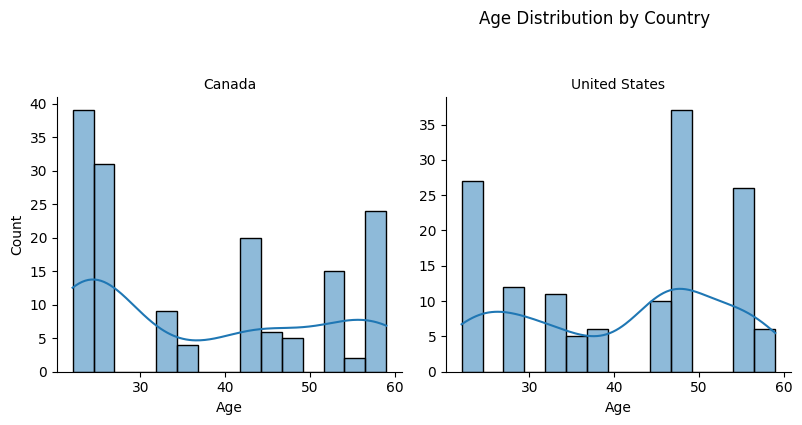

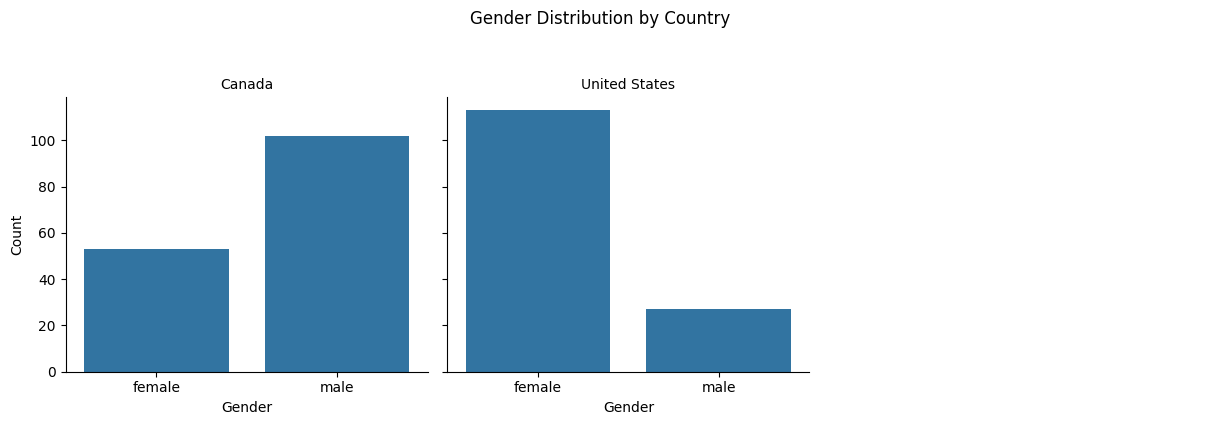

In [116]:
df = pd.read_excel('Telus Health Quote Spreadsheet.xlsx', engine='openpyxl')

# Add this after your existing preprocessing code
demographic_stats = df.groupby('Country').agg({
    'Age': ['mean', 'median', 'std', 'min', 'max'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict(),
    'Coverage (%)': ['mean', 'median', 'std']
})

print("\nDemographic Summary Statistics by Country:")
print(demographic_stats)

# Drop missing age or country values
age_df = df.dropna(subset=["Age", "Country"])

# Plot histogram
g = sns.displot(
    data=age_df,
    x="Age",
    col="Country",
    bins=15,
    kde=True,
    col_wrap=3,
    height=4,
    facet_kws={'sharey': False, 'sharex': True}
)

g.set_titles("{col_name}")
g.set_axis_labels("Age", "Count")
plt.suptitle("Age Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


# Drop missing gender or country
gender_df = df.dropna(subset=["Gender", "Country"])

# Plot
g = sns.catplot(
    data=gender_df,
    x="Gender",
    col="Country",
    kind="count",
    col_wrap=3,
    height=4,
    order=gender_df["Gender"].value_counts().index
)

g.set_titles("{col_name}")
g.set_axis_labels("Gender", "Count")
plt.suptitle("Gender Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


In [117]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

random.seed(365)
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set environment variable for macOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Load data
df = pd.read_excel('Telus Health Quote Spreadsheet.xlsx', engine='openpyxl')

# Preprocessing
feature_columns = ['Theme', 'Sub-theme', 'Coverage (%)', 'Age', 'Gender']
target_column = 'Country'

# Convert sparse matrix to dense if needed
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme', 'Sub-theme', 'Gender'])
    ],
    remainder='passthrough'
)

combined_features = preprocessor.fit_transform(df[feature_columns])
# Convert to dense array if it's sparse (common with OneHotEncoder)
if hasattr(combined_features, 'toarray'):
    combined_features = combined_features.toarray()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df[target_column])

print("Combined features shape:", combined_features.shape)
print("Encoded labels shape:", encoded_labels.shape)

# XGBoost setup
XGB_INSTALLED = False
try:
    import xgboost
    from xgboost import XGBClassifier
    print(f"XGBoost {xgboost.__version__} is installed")
    XGB_INSTALLED = True
except ImportError:
    print("XGBoost not found, attempting installation...")
    try:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "--no-cache-dir"])
        import xgboost
        from xgboost import XGBClassifier
        print(f"Successfully installed XGBoost {xgboost.__version__}")
        XGB_INSTALLED = True
    except Exception as e:
        print(f"Failed to install XGBoost: {str(e)}")
        print("Will proceed without XGBoost")

def create_ensemble_model():
    estimators = [
        ('logistic', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', SVC(kernel='linear', C=1, probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]
    
    if XGB_INSTALLED:
        estimators.append(('xgb', XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            n_jobs=1
        )))
        print("Including XGBoost in the ensemble")
    
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=1
    )

def safe_cross_val_predict(model, X, y, cv):
    # Always use sequential processing to avoid serialization issues
    return cross_val_predict(
        model, X, y,
        cv=cv,
        n_jobs=1,
        method='predict_proba',
        verbose=1
    )

def run_classification(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    model = create_ensemble_model()
    predictions = safe_cross_val_predict(model, X, y, kf)
    predicted_classes = np.argmax(predictions, axis=1)
    return predicted_classes, predictions

try:
    predicted_classes, prediction_probs = run_classification(combined_features, encoded_labels)
    
    # Compute metrics
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nClassification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Add probability analysis
    print("\nProbability Analysis:")
    print(f"Average confidence for correct predictions: {np.max(prediction_probs[encoded_labels == predicted_classes]).mean():.4f}")
    print(f"Average confidence for incorrect predictions: {np.max(prediction_probs[encoded_labels != predicted_classes]).mean():.4f}")
    
except Exception as e:
    print(f"Major error occurred: {str(e)}")
    print("Trying fallback with just Logistic Regression...")
    
    lr = LogisticRegression(max_iter=1000, random_state=42)
    predicted_classes = cross_val_predict(lr, combined_features, encoded_labels, cv=5, n_jobs=1, method='predict')
    
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, 
                                       target_names=label_encoder.classes_)
    
    print("\nFallback Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

Combined features shape: (295, 16)
Encoded labels shape: (295,)
XGBoost 3.0.2 is installed
Including XGBoost in the ensemble

Classification Results:
Accuracy: 0.8949

Classification Report:
               precision    recall  f1-score   support

       Canada       0.90      0.90      0.90       155
United States       0.89      0.89      0.89       140

     accuracy                           0.89       295
    macro avg       0.89      0.89      0.89       295
 weighted avg       0.89      0.89      0.89       295


Confusion Matrix:
[[139  16]
 [ 15 125]]

Probability Analysis:
Average confidence for correct predictions: 0.9669
Average confidence for incorrect predictions: 0.8829


Including XGBoost in the ensemble

Analyzing feature importance...


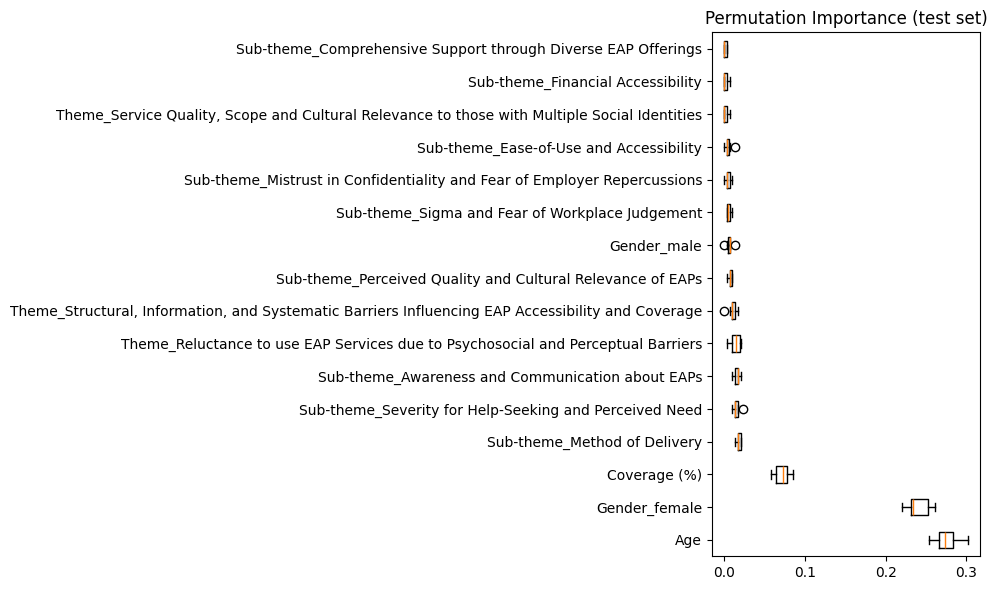


Top features distinguishing countries:
Age: 0.2753
Gender_female: 0.2403
Coverage (%): 0.0712
Sub-theme_Method of Delivery: 0.0176
Sub-theme_Severity for Help-Seeking and Perceived Need: 0.0153
Sub-theme_Awareness and Communication about EAPs: 0.0153
Theme_Reluctance to use EAP Services due to Psychosocial and Perceptual Barriers: 0.0139
Theme_Structural, Information, and Systematic Barriers Influencing EAP Accessibility and Coverage: 0.0108
Sub-theme_Perceived Quality and Cultural Relevance of EAPs: 0.0075
Gender_male: 0.0061

Theme/Sub-theme distribution by country:
Sub-theme                                                         Awareness and Communication about EAPs  \
Country       Theme                                                                                        
Canada        Reluctance to use EAP Services due to Psychosoc...                                       0   
              Service Quality, Scope and Cultural Relevance t...                                    

In [118]:
# Add these imports at the top
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# After your classification code, add feature analysis:

def analyze_feature_importance(model, feature_names, X, y):
    # Get permutation importance
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=1
    )
    
    # Sort features by importance
    sorted_idx = result.importances_mean.argsort()[::-1]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=np.array(feature_names)[sorted_idx]
    )
    plt.title("Permutation Importance (test set)")
    plt.tight_layout()
    plt.show()
    
    # Return top features
    top_features = np.array(feature_names)[sorted_idx]
    top_importances = result.importances_mean[sorted_idx]
    return list(zip(top_features, top_importances))

# Get feature names from the preprocessor
try:
    # For one-hot encoded features
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['Theme', 'Sub-theme', 'Gender'])
    num_features = ['Coverage (%)', 'Age']  # Numerical features passed through
    feature_names = list(cat_features) + num_features
    
    # Train a final model for analysis (not cross-validated)
    final_model = create_ensemble_model()
    final_model.fit(combined_features, encoded_labels)
    
    # Analyze feature importance
    print("\nAnalyzing feature importance...")
    important_features = analyze_feature_importance(final_model, feature_names, combined_features, encoded_labels)
    
    print("\nTop features distinguishing countries:")
    for feature, importance in important_features[:10]:  # Show top 10
        print(f"{feature}: {importance:.4f}")
        
    # Analyze specific themes/subthemes by country
    print("\nTheme/Sub-theme distribution by country:")
    theme_counts = df.groupby(['Country', 'Theme', 'Sub-theme']).size().unstack(fill_value=0)
    print(theme_counts)
    
    # Add normalized percentages
    theme_pcts = theme_counts.div(theme_counts.sum(axis=1), axis=0)
    print("\nNormalized percentages:")
    print(theme_pcts)
    
except Exception as e:
    print(f"Could not analyze features: {str(e)}")

## Removing Age and Gender

In [119]:
from sklearn.utils import resample

# Check original counts
print("Original counts:\n", df['Country'].value_counts())

# Separate by country
df_canada = df[df['Country'] == 'Canada']
df_us = df[df['Country'] == 'United States']

# Downsample US to match Canada (since US has more samples)
df_canada_balanced = resample(df_canada,
                         replace=False,  # Without replacement
                         n_samples=len(df_us),
                         random_state=42)  # For reproducibility

# Combine balanced samples
balanced_df = pd.concat([df_us, df_canada_balanced])

# Verify new counts
print("\nBalanced counts:\n", balanced_df['Country'].value_counts())

# Check balanced demographics
print("\nBalanced Age Stats:")
print(balanced_df.groupby('Country')['Age'].describe())

print("\nBalanced Gender Distribution:")
print(balanced_df.groupby('Country')['Gender'].value_counts(normalize=True))

Original counts:
 Country
Canada           155
United States    140
Name: count, dtype: int64

Balanced counts:
 Country
United States    140
Canada           140
Name: count, dtype: int64

Balanced Age Stats:
               count       mean        std   min   25%   50%   75%   max
Country                                                                 
Canada         140.0  37.000000  14.074826  22.0  24.0  32.0  54.0  59.0
United States  140.0  40.742857  11.906936  22.0  29.0  46.0  47.0  57.0

Balanced Gender Distribution:
Country        Gender
Canada         male      0.664286
               female    0.335714
United States  female    0.807143
               male      0.192857
Name: proportion, dtype: float64


In [120]:
# 1. PREPROCESS BALANCED DATA
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme', 'Sub-theme', 'Gender'])
    ],
    remainder='passthrough'
)

balanced_features = preprocessor.fit_transform(balanced_df[feature_columns])
if hasattr(balanced_features, 'toarray'):
    balanced_features = balanced_features.toarray()

label_encoder = LabelEncoder()
balanced_labels = label_encoder.fit_transform(balanced_df[target_column])

# 2. MODIFIED CLASSIFICATION PIPELINE (WITH DEMOGRAPHIC CONTROL)
def run_controlled_classification(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Model with balanced class weights
    estimators = [
        ('logistic', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
        ('svm', SVC(kernel='linear', C=1, probability=True, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]
    
    if XGB_INSTALLED:
        estimators.append(('xgb', XGBClassifier(
            scale_pos_weight=len(y[y==0])/len(y[y==1]),  # Handle imbalance
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )))
    
    model = VotingClassifier(estimators=estimators, voting='soft', n_jobs=1)
    
    # Feature importance will be more reliable now
    predictions = cross_val_predict(model, X, y, cv=kf, n_jobs=1, method='predict_proba')
    return np.argmax(predictions, axis=1), predictions

# 3. RUN AND ANALYZE
try:
    pred_classes, pred_probs = run_controlled_classification(balanced_features, balanced_labels)
    
    print("\n=== BALANCED DATASET RESULTS ===")
    print(f"Accuracy: {accuracy_score(balanced_labels, pred_classes):.4f}")
    print("\nClassification Report:")
    print(classification_report(balanced_labels, pred_classes, target_names=label_encoder.classes_))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(balanced_labels, pred_classes))
    
    # Feature Importance Analysis
    final_model = create_ensemble_model()
    final_model.fit(balanced_features, balanced_labels)
    
    print("\n=== FEATURE IMPORTANCE ===")
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['Theme', 'Sub-theme', 'Gender'])
    num_features = ['Coverage (%)', 'Age']
    all_features = list(cat_features) + num_features
    
    # Get permutation importance
    perm_importance = permutation_importance(
        final_model, balanced_features, balanced_labels,
        n_repeats=10, random_state=42
    )
    
    # Display top features
    top_idx = perm_importance.importances_mean.argsort()[::-1]
    top_features = np.array(all_features)[top_idx]
    top_scores = perm_importance.importances_mean[top_idx]
    
    for feat, score in zip(top_features[:10], top_scores[:10]):
        print(f"{feat}: {score:.4f}")
    
except Exception as e:
    print(f"Error: {str(e)}")
    # Fallback to logistic regression
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(balanced_features, balanced_labels)
    # ... (fallback analysis)


=== BALANCED DATASET RESULTS ===
Accuracy: 0.8857

Classification Report:
               precision    recall  f1-score   support

       Canada       0.89      0.88      0.88       140
United States       0.88      0.89      0.89       140

     accuracy                           0.89       280
    macro avg       0.89      0.89      0.89       280
 weighted avg       0.89      0.89      0.89       280


Confusion Matrix:
[[123  17]
 [ 15 125]]
Including XGBoost in the ensemble

=== FEATURE IMPORTANCE ===
Age: 0.2693
Gender_female: 0.2229
Coverage (%): 0.0668
Sub-theme_Method of Delivery: 0.0218
Sub-theme_Severity for Help-Seeking and Perceived Need: 0.0186
Sub-theme_Awareness and Communication about EAPs: 0.0136
Sub-theme_Perceived Quality and Cultural Relevance of EAPs: 0.0125
Theme_Structural, Information, and Systematic Barriers Influencing EAP Accessibility and Coverage: 0.0121
Theme_Reluctance to use EAP Services due to Psychosocial and Perceptual Barriers: 0.0100
Sub-theme_Fina

Balanced Accuracy: 0.8143

Classification Report:
              precision    recall  f1-score   support

      Canada       0.82      0.81      0.81       140
          US       0.81      0.82      0.82       140

    accuracy                           0.81       280
   macro avg       0.81      0.81      0.81       280
weighted avg       0.81      0.81      0.81       280


Confusion Matrix:
[[113  27]
 [ 25 115]]

Top Features:
Gender_female: 0.1570
Age: 0.1107
Gender_male: 0.0671
quote_10: 0.0518
quote_11: 0.0448
quote_42: 0.0391
quote_22: 0.0315
quote_9: 0.0303
quote_0: 0.0275
quote_8: 0.0269


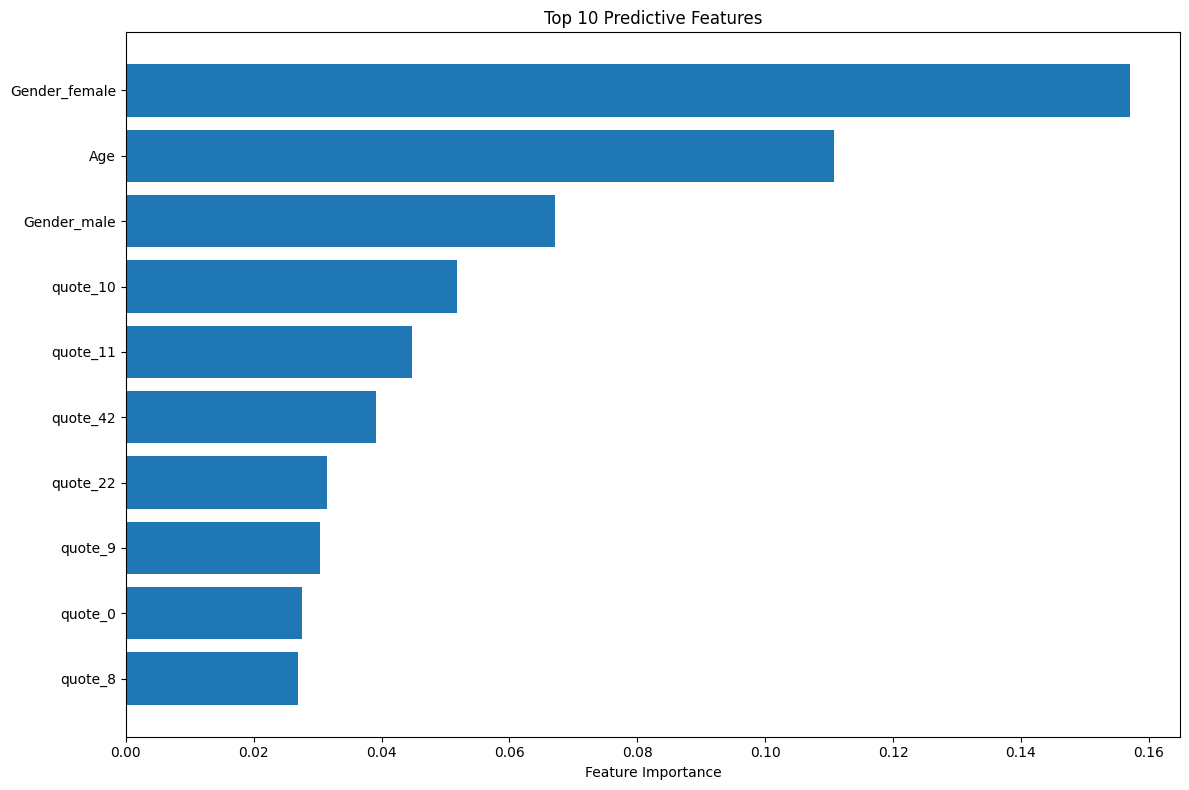

In [121]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler  # Changed to MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt


# Feature engineering
balanced_df['Theme_Subtheme'] = balanced_df['Theme'] + "|" + balanced_df['Sub-theme']
balanced_df['Coverage_bin'] = pd.cut(balanced_df['Coverage (%)'], bins=3, labels=['low','med','high'])

# Text feature extraction
tfidf = TfidfVectorizer(max_features=50, stop_words='english', ngram_range=(1,2))
quote_features = tfidf.fit_transform(balanced_df['Quote'])

# Preprocessing pipeline - Using MinMaxScaler instead of StandardScaler
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme_Subtheme', 'Gender', 'Coverage_bin']),
    ('num', MinMaxScaler(), ['Age'])  # Now produces only non-negative values
])

# Process features
X_processed = preprocessor.fit_transform(balanced_df)
y = LabelEncoder().fit_transform(balanced_df['Country'])

# Feature selection - Now works with chi2
selector = SelectKBest(chi2, k=min(30, X_processed.shape[1]))  # Ensure k <= n_features
X_selected = selector.fit_transform(X_processed, y)

# Combine with text features
final_features = np.hstack([X_selected.toarray(), quote_features.toarray()])

# Model definition
def create_tuned_ensemble():
    estimators = []
    
    # Tuned Logistic Regression
    estimators.append(('lr', LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='saga',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )))
    
    # Tuned Random Forest
    estimators.append(('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )))
    
    # Tuned SVM
    estimators.append(('svm', SVC(
        C=1,
        kernel='rbf',
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=42
    )))
    
    # Neural Network
    estimators.append(('mlp', MLPClassifier(
        hidden_layer_sizes=(50,),
        alpha=0.01,
        early_stopping=True,
        random_state=42
    )))
    
    # XGBoost if available
    try:
        estimators.append(('xgb', XGBClassifier(
            learning_rate=0.1,
            max_depth=3,
            n_estimators=150,
            scale_pos_weight=sum(y==0)/sum(y==1),
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )))
    except:
        pass
    
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=1
    )

# Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = create_tuned_ensemble()

preds = cross_val_predict(
    model,
    final_features,
    y,
    cv=cv,
    method='predict_proba',
    n_jobs=1
)
pred_classes = np.argmax(preds, axis=1)

# Results
print(f"Balanced Accuracy: {accuracy_score(y, pred_classes):.4f}")
print("\nClassification Report:")
print(classification_report(y, pred_classes, target_names=['Canada', 'US']))
print("\nConfusion Matrix:")
print(confusion_matrix(y, pred_classes))

# Feature importance analysis
model.fit(final_features, y)
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    # For voting classifier, get average importance
    importances = np.mean([
        est.feature_importances_ 
        for est in model.estimators_ 
        if hasattr(est, 'feature_importances_')
    ], axis=0)


# Get feature names
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
num_features = ['Age']
structured_features = list(cat_features) + num_features
selected_structured = [structured_features[i] for i in selector.get_support(indices=True)]

# Quote feature names
quote_feature_names = [f"quote_{i}" for i in range(quote_features.shape[1])]

# Final feature name list
selected_features = selected_structured + quote_feature_names

# Display top features
top_idx = np.argsort(importances)[::-1][:10]

print("\nTop Features:")
for idx in top_idx:
    print(f"{selected_features[idx]}: {importances[idx]:.4f}")

# Visualization
plt.figure(figsize=(12, 8))
plt.barh(range(10), importances[top_idx[:10]][::-1], align='center')
plt.yticks(range(10), [selected_features[i] for i in top_idx[:10][::-1]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Predictive Features")
plt.tight_layout()
plt.show()


Balanced Accuracy: 0.6475

Classification Report:
              precision    recall  f1-score   support

      Canada       0.65      0.71      0.68       155
          US       0.64      0.58      0.61       140

    accuracy                           0.65       295
   macro avg       0.65      0.64      0.64       295
weighted avg       0.65      0.65      0.65       295


Confusion Matrix:
[[110  45]
 [ 59  81]]

Top Features:
quote_29: 0.0508
quote_42: 0.0507
quote_10: 0.0484
quote_23: 0.0416
quote_22: 0.0378
quote_11: 0.0355
quote_9: 0.0350
quote_43: 0.0333
quote_20: 0.0322
quote_4: 0.0264


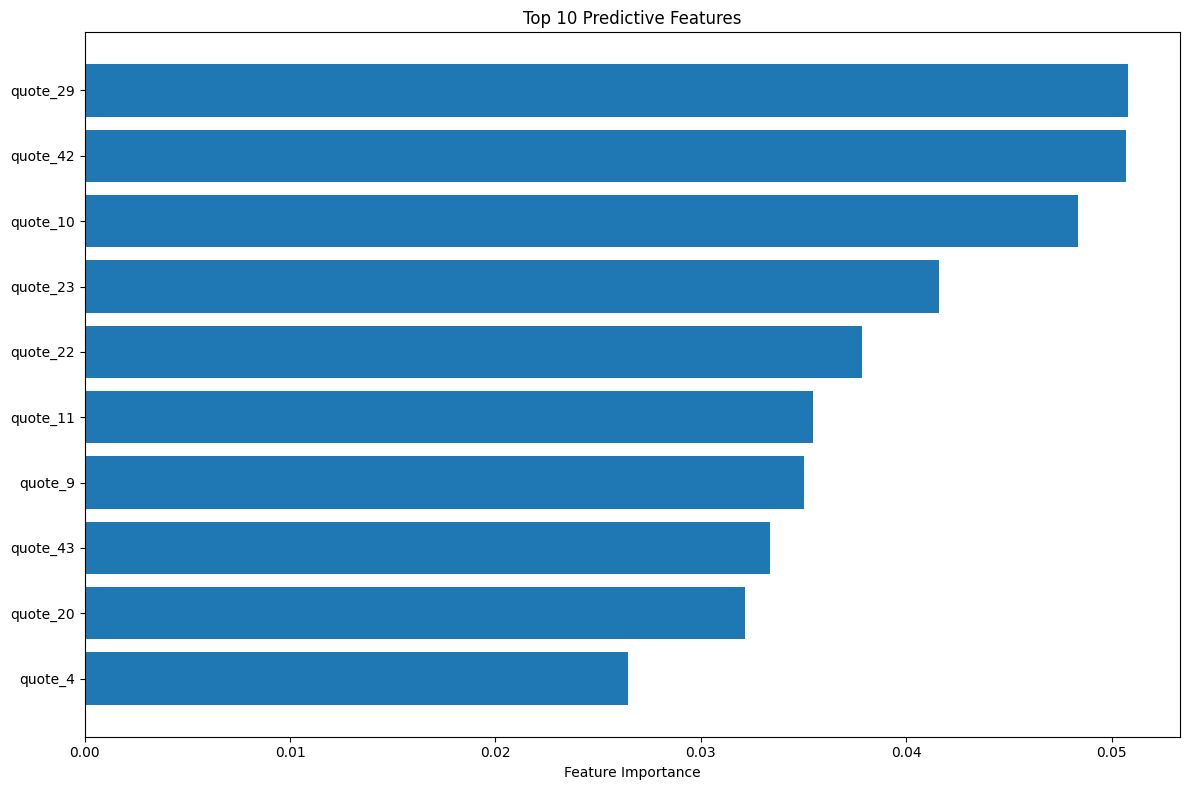

In [122]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler  # Changed to MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt

random.seed(123)

# Feature engineering
df['Theme_Subtheme'] = df['Theme'] + "|" + df['Sub-theme']
df['Coverage_bin'] = pd.cut(df['Coverage (%)'], bins=3, labels=['low','med','high'])

# Text feature extraction
tfidf = TfidfVectorizer(max_features=50, stop_words='english', ngram_range=(1,2))
quote_features = tfidf.fit_transform(df['Quote'])

# Preprocessing pipeline - Using MinMaxScaler instead of StandardScaler
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme_Subtheme', 'Coverage_bin'])
    ])

# Process features
X_processed = preprocessor.fit_transform(df)
y = LabelEncoder().fit_transform(df['Country'])

# Feature selection - Now works with chi2
selector = SelectKBest(chi2, k=min(30, X_processed.shape[1]))  # Ensure k <= n_features
X_selected = selector.fit_transform(X_processed, y)

# Combine with text features
final_features = np.hstack([X_selected.toarray(), quote_features.toarray()])

# Model definition
def create_tuned_ensemble():
    estimators = []
    
    # Tuned Logistic Regression
    estimators.append(('lr', LogisticRegression(
        C=0.1,
        penalty='l2',
        solver='saga',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )))
    
    # Tuned Random Forest
    estimators.append(('rf', RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        min_samples_split=5,
        class_weight='balanced',
        random_state=42
    )))
    
    # Tuned SVM
    estimators.append(('svm', SVC(
        C=1,
        kernel='rbf',
        gamma='scale',
        probability=True,
        class_weight='balanced',
        random_state=42
    )))
    
    # Neural Network
    estimators.append(('mlp', MLPClassifier(
        hidden_layer_sizes=(50,),
        alpha=0.01,
        early_stopping=True,
        random_state=42
    )))
    
    # XGBoost if available
    try:
        estimators.append(('xgb', XGBClassifier(
            learning_rate=0.1,
            max_depth=3,
            n_estimators=150,
            scale_pos_weight=sum(y==0)/sum(y==1),
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )))
    except:
        pass
    
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=1
    )

# Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = create_tuned_ensemble()

preds = cross_val_predict(
    model,
    final_features,
    y,
    cv=cv,
    method='predict_proba',
    n_jobs=1
)
pred_classes = np.argmax(preds, axis=1)

# Results
print(f"Balanced Accuracy: {accuracy_score(y, pred_classes):.4f}")
print("\nClassification Report:")
print(classification_report(y, pred_classes, target_names=['Canada', 'US']))
print("\nConfusion Matrix:")
print(confusion_matrix(y, pred_classes))

# Feature importance analysis
model.fit(final_features, y)
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    # For voting classifier, get average importance
    importances = np.mean([
        est.feature_importances_ 
        for est in model.estimators_ 
        if hasattr(est, 'feature_importances_')
    ], axis=0)


# Get feature names
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
structured_features = list(cat_features) 
selected_structured = [structured_features[i] for i in selector.get_support(indices=True)]

# Quote feature names
quote_feature_names = [f"quote_{i}" for i in range(quote_features.shape[1])]

# Final feature name list
selected_features = selected_structured + quote_feature_names

# Display top features
top_idx = np.argsort(importances)[::-1][:10]

print("\nTop Features:")
for idx in top_idx:
    print(f"{selected_features[idx]}: {importances[idx]:.4f}")

# Visualization
plt.figure(figsize=(12, 8))
plt.barh(range(10), importances[top_idx[:10]][::-1], align='center')
plt.yticks(range(10), [selected_features[i] for i in top_idx[:10][::-1]])
plt.xlabel("Feature Importance")
plt.title("Top 10 Predictive Features")
plt.tight_layout()
plt.show()


## Matching with Propensity Scores

In [123]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

def propensity_score_matching(df, treatment_col='Country', treatment='United States'):
    # Calculate propensity scores
    X = df[['Age', 'Gender']].copy()
    X['Gender'] = X['Gender'].map({'male': 0, 'female': 1})  # Convert to numeric
    y = (df[treatment_col] == treatment).astype(int)
    
    # Fit logistic regression to get propensity scores
    logit = LogisticRegression(max_iter=1000)
    logit.fit(X, y)
    df['propensity_score'] = logit.predict_proba(X)[:, 1]
    
    # Separate treatment and control groups
    treatment_df = df[df[treatment_col] == treatment]
    control_df = df[df[treatment_col] != treatment]
    
    # Perform matching (1:1 nearest neighbor matching without replacement)
    nbrs = NearestNeighbors(n_neighbors=1).fit(control_df[['propensity_score']])
    distances, indices = nbrs.kneighbors(treatment_df[['propensity_score']])
    
    # Create matched control group
    matched_control = control_df.iloc[indices.flatten()]
    
    # Combine matched samples
    matched_df = pd.concat([treatment_df, matched_control])
    
    return matched_df

# Apply propensity score matching
matched_df = propensity_score_matching(df)

# Verify balance
print("\nMatched counts:\n", matched_df['Country'].value_counts())

print("\nMatched Age Stats:")
print(matched_df.groupby('Country')['Age'].describe())

print("\nMatched Gender Distribution:")
print(matched_df.groupby('Country')['Gender'].value_counts(normalize=True))


Matched counts:
 Country
United States    140
Canada           140
Name: count, dtype: int64

Matched Age Stats:
               count       mean        std   min   25%   50%   75%   max
Country                                                                 
Canada         140.0  39.278571  11.720405  22.0  32.0  43.0  46.0  59.0
United States  140.0  40.742857  11.906936  22.0  29.0  46.0  47.0  57.0

Matched Gender Distribution:
Country        Gender
Canada         female    0.807143
               male      0.192857
United States  female    0.807143
               male      0.192857
Name: proportion, dtype: float64



Demographic Summary Statistics by Country:
                     Age                            \
                    mean median        std min max   
Country                                              
Canada         39.278571   43.0  11.720405  22  59   
United States  40.742857   46.0  11.906936  22  57   

                                                          Gender Coverage (%)  \
                                                        <lambda>         mean   
Country                                                                         
Canada         {'female': 0.8071428571428572, 'male': 0.19285...     0.821357   
United States  {'female': 0.8071428571428572, 'male': 0.19285...     1.053643   

                                
              median       std  
Country                         
Canada          0.88  0.394515  
United States   0.86  0.774107  


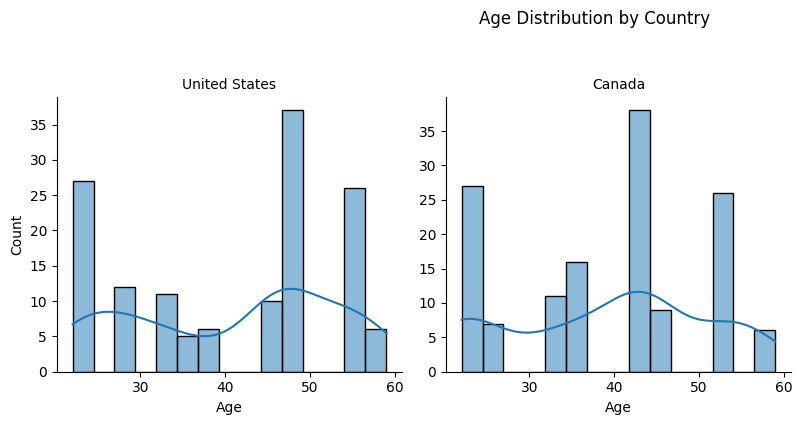

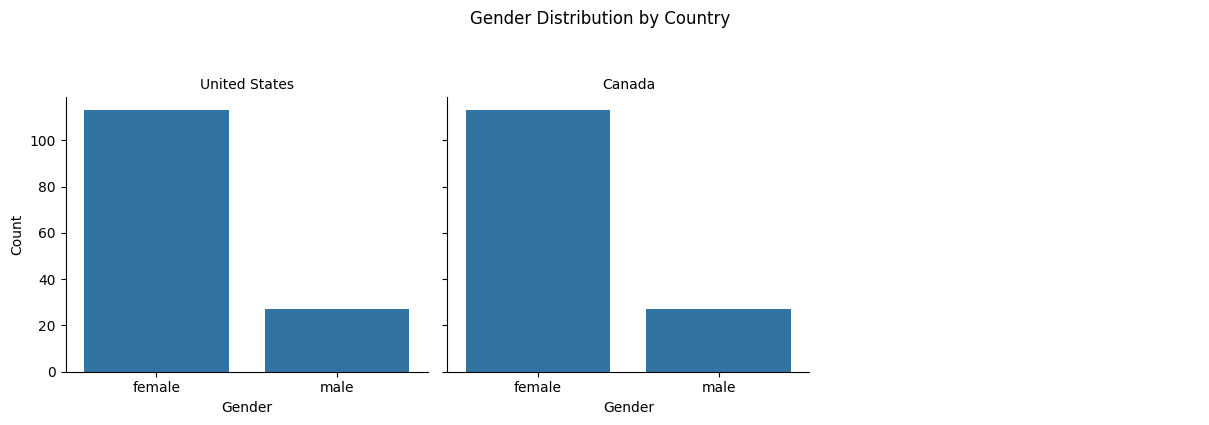

In [124]:

# Add this after your existing preprocessing code
demographic_stats = matched_df.groupby('Country').agg({
    'Age': ['mean', 'median', 'std', 'min', 'max'],
    'Gender': lambda x: x.value_counts(normalize=True).to_dict(),
    'Coverage (%)': ['mean', 'median', 'std']
})

print("\nDemographic Summary Statistics by Country:")
print(demographic_stats)

# Drop missing age or country values
age_df = matched_df.dropna(subset=["Age", "Country"])

# Plot histogram
g = sns.displot(
    data=age_df,
    x="Age",
    col="Country",
    bins=15,
    kde=True,
    col_wrap=3,
    height=4,
    facet_kws={'sharey': False, 'sharex': True}
)

g.set_titles("{col_name}")
g.set_axis_labels("Age", "Count")
plt.suptitle("Age Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


# Drop missing gender or country
gender_df = matched_df.dropna(subset=["Gender", "Country"])

# Plot
g = sns.catplot(
    data=gender_df,
    x="Gender",
    col="Country",
    kind="count",
    col_wrap=3,
    height=4,
    order=gender_df["Gender"].value_counts().index
)

g.set_titles("{col_name}")
g.set_axis_labels("Gender", "Count")
plt.suptitle("Gender Distribution by Country", y=1.05)
plt.tight_layout()
plt.show()


In [125]:
random.seed(365)
# 1. PREPROCESS BALANCED DATA
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Theme', 'Sub-theme', 'Gender'])
    ],
    remainder='passthrough'
)

balanced_features = preprocessor.fit_transform(matched_df[feature_columns])
if hasattr(balanced_features, 'toarray'):
    balanced_features = balanced_features.toarray()

label_encoder = LabelEncoder()
balanced_labels = label_encoder.fit_transform(matched_df[target_column])

# 2. MODIFIED CLASSIFICATION PIPELINE (WITH DEMOGRAPHIC CONTROL)
def run_controlled_classification(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Model with balanced class weights
    estimators = [
        ('logistic', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)),
        ('svm', SVC(kernel='linear', C=1, probability=True, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]
    
    if XGB_INSTALLED:
        estimators.append(('xgb', XGBClassifier(
            scale_pos_weight=len(y[y==0])/len(y[y==1]),  # Handle imbalance
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )))
    
    model = VotingClassifier(estimators=estimators, voting='soft', n_jobs=1)
    
    # Feature importance will be more reliable now
    predictions = cross_val_predict(model, X, y, cv=kf, n_jobs=1, method='predict_proba')
    return np.argmax(predictions, axis=1), predictions

# 3. RUN AND ANALYZE
try:
    pred_classes, pred_probs = run_controlled_classification(balanced_features, balanced_labels)
    
    print("\n=== BALANCED DATASET RESULTS ===")
    print(f"Accuracy: {accuracy_score(balanced_labels, pred_classes):.4f}")
    print("\nClassification Report:")
    print(classification_report(balanced_labels, pred_classes, target_names=label_encoder.classes_))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(balanced_labels, pred_classes))
    
    # Feature Importance Analysis
    final_model = create_ensemble_model()
    final_model.fit(balanced_features, balanced_labels)
    
    print("\n=== FEATURE IMPORTANCE ===")
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['Theme', 'Sub-theme', 'Gender'])
    num_features = ['Coverage (%)', 'Age']
    all_features = list(cat_features) + num_features
    
    # Get permutation importance
    perm_importance = permutation_importance(
        final_model, balanced_features, balanced_labels,
        n_repeats=10, random_state=42
    )
    
    # Display top features
    top_idx = perm_importance.importances_mean.argsort()[::-1]
    top_features = np.array(all_features)[top_idx]
    top_scores = perm_importance.importances_mean[top_idx]
    
    for feat, score in zip(top_features[:10], top_scores[:10]):
        print(f"{feat}: {score:.4f}")
    
except Exception as e:
    print(f"Error: {str(e)}")
    


=== BALANCED DATASET RESULTS ===
Accuracy: 0.9286

Classification Report:
               precision    recall  f1-score   support

       Canada       0.88      1.00      0.93       140
United States       1.00      0.86      0.92       140

     accuracy                           0.93       280
    macro avg       0.94      0.93      0.93       280
 weighted avg       0.94      0.93      0.93       280


Confusion Matrix:
[[140   0]
 [ 20 120]]
Including XGBoost in the ensemble

=== FEATURE IMPORTANCE ===
Age: 0.2579
Sub-theme_Severity for Help-Seeking and Perceived Need: 0.2132
Coverage (%): 0.1636
Gender_female: 0.0836
Sub-theme_Perceived Quality and Cultural Relevance of EAPs: 0.0811
Gender_male: 0.0207
Theme_Structural, Information, and Systematic Barriers Influencing EAP Accessibility and Coverage: 0.0029
Sub-theme_Method of Delivery: 0.0025
Theme_Service Quality, Scope and Cultural Relevance to those with Multiple Social Identities: 0.0004
Sub-theme_Sigma and Fear of Workplace J

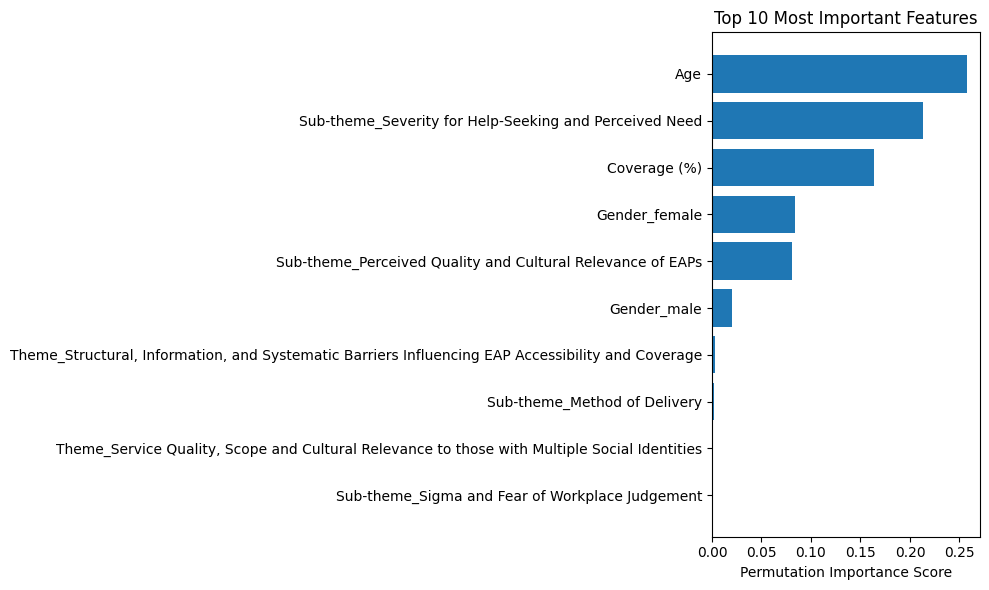

In [127]:
import matplotlib.pyplot as plt

# After your permutation importance calculation
plt.figure(figsize=(10, 6))
plt.barh(top_features[:10][::-1], top_scores[:10][::-1])
plt.xlabel("Permutation Importance Score")
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.show()